In [61]:

import random

import numpy as np
from matplotlib import pyplot as plt

from vqr import VectorQuantileRegressor
from experiments.data.mvn import LinearMVNDataProvider
from vqr.solvers.dual.regularized_lse import (
    RegularizedDualVQRSolver,
    MLPRegularizedDualVQRSolver,
)

N = 10000
# d = 2
d = 1
k = 2
T = 40
data_provider = LinearMVNDataProvider(d=d, k=k)
X, Y = data_provider.sample(n=N)

In [62]:


vqr_solver = MLPRegularizedDualVQRSolver(
    verbose=True,
    lr=0.5,
    epsilon=1e-6,
    num_epochs=5000,
    hidden_layers=(2, 10),
    skip=False,
)
vqr = VectorQuantileRegressor(n_levels=T, solver=vqr_solver)
vqr.fit(X, Y)

  0%|                                                                  | 0/5000 [00:00<?, ?epochs/s]

VectorQuantileRegressor(n_levels=40,
                        solver=MLPRegularizedDualVQRSolver(eps=1e-06))

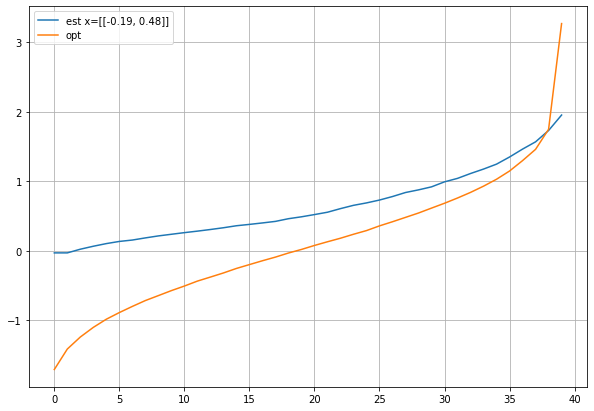

In [76]:

###
i = random.randrange(0, N)
x = X[[i]]
q = vqr.vector_quantiles(X=x)[0][0]

_, Y_ = data_provider.sample(n=N, x=x)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(q, label=f"est x={x.round(decimals=2).tolist()}")
ax.plot(np.quantile(Y, q=vqr.quantile_levels), label="opt")
ax.legend()
ax.grid()
###